In [169]:
import PIL.Image as Image
import imageio
import pylab as py
%matplotlib inline
import numpy as np
import csv
import warnings
from numpy.linalg import eig, inv

In [170]:
csv_file = '20180921_JP_470_8.csv'
#threshold = 40
input_frame = '20180921_JP_470_8/frame{:d}.jpg'
output_frame = '20180921_JP_470_8_circles/frame{:d}.jpg'
test_frame = '20180921_JP_470_8/frame1.jpg'
first_frame = '20180921_JP_470_8/frame1.jpg'
n_frame = 2881
estimate_center = np.array([600,600])
estimate_radius = 300

In [171]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])   
        
    Source code: https://stackoverflow.com/questions/32328179/opencv-3-0-python-lineiterator
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

In [172]:
'''Idea from: https://stackoverflow.com/questions/45922566/ellipse-fitting-for-pupil-center'''

def find_edge_points(center, radius, img, d_theta = np.pi/180 ):
#    r = 2 * radius
    r = 500
    points = []
    
    for theta in np.arange(0, 2*np.pi, d_theta):
        end_point_x = (center[0] + r*np.cos(theta)).astype(np.int)
        end_point_y = (center[1] + r*np.sin(theta)).astype(np.int)
        end_point = np.array([end_point_x,end_point_y])
        result = createLineIterator(center, end_point, img)

        '''need to twiddle more to find a better way to find the edge points'''
#        diff = []
#        sum_lum = []
#        for i in range(1,len(result)):
#            diff.append(result[i][2] - result[i-1][2])
#        for i in range(len(diff)):    
#            sum_lum.append(sum(diff[:i]))
        #print(sum_lum)
#        for i in range(2,len(sum_lum)):
#            if sum_lum[i] > 3 * sum_lum[i-1] and sum_lum[i-1] > 3 * sum_lum[i-2] and sum_lum[i-1] > 0:
#                points.append((result[i][0],result[i][1]))
#                break

        edge_detected = False
        glare_detected = False
        
        for i in range(len(result)):
            
            if result[i][2] == 255:
                edge_detected = True
                
            if edge_detected:
                for j in range(i,len(result)-i):
                    if result[j][2] == 0:
                        glare_detected = True
                        break
            if edge_detected and not glare_detected:
                points.append((result[i][0],result[i][1]))
                break
    return points

'''http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html'''

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


def ellipse_angle_of_rotation( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return 0.5*np.arctan(2*b/(a-c))

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [173]:
def image_thresholding(img,threshold):
    threshold_pupil = threshold  
#    idx1 = img[:,:] > threshold_pupil
#    idx2 = img[:,:] < threshold_pupil
    idx1 =  threshold_pupil < img[:,:] 
    idx2 = img[:,:] < threshold_pupil 
#    idx3 = img[:,:] > 1.5*threshold_pupil
    img[idx1] = 255
    img[idx2] = 0
#    img[idx3] = 0
    return img
    
def get_image_mat(filename):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    return img

def get_binary_image_mat(filename,threshold):
    img = Image.open(filename).convert('LA')
    #img = img.resize((120, 100), Image.ANTIALIAS)
    img = np.asarray(img, 'double').transpose()  
    img = img[0,:,:] # just one layer
    img = image_thresholding(img,threshold)
    return img

def show_image(img):
    py.imshow(img.transpose(), cmap=py.cm.Greys_r)
    
def add_circle(img_mat,center,radius,luminance=255):
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-0.5, 0, 0.5]: # give width to the circle for viewing
            x = int(center[0] + (radius+width) * np.cos(rad))
            y = int(center[1] + (radius+width) * np.sin(rad))
            img_mat.transpose()[x,y] = luminance
    return


def add_ellipse(img_mat,center,a,b,phi,luminance=255):
    c = np.sqrt(a*a-b*b)
    e = c/a
    for rad in np.arange(0,2*np.pi, 0.01):
        for width in [-1, -0.5, 0, 0.5, 1]: # give width to the circle for viewing
            #r = a*(1-e*e)/(1+e*np.cos(rad))
            #x = int(center[0] + c + r * np.cos(rad))
            #y = int(center[1] + r * np.sin(rad))
            x = int(center[0] + (a+width)*np.cos(rad)*np.cos(phi) - (b+width)*np.sin(rad)*np.sin(phi))
            y = int(center[1] + (a+width)*np.cos(rad)*np.sin(phi) + (b+width)*np.sin(rad)*np.cos(phi))
            img_mat.transpose()[x,y] = luminance
    return

def save_image(img, center, radius, a, b, phi, file_name, lum = 255):
    show_circle_img = img.copy()
    add_circle(show_circle_img,center,radius,lum)
    #add_ellipse(show_circle_img,center,a,b,phi,lum)
    imageio.imwrite(file_name, show_circle_img.transpose())
    return

def export_to_csv(radius_data):
    with open (csv_file, 'w') as csvfile:
        writer = csv.writer(csvfile, lineterminator = '\n', delimiter=' ')
        for num in radius_data:
            writer.writerow([num])
    return

def isNaN(num):
    return num != num


[[ 39.  39.  40. ...,  43.  44.  44.]
 [ 40.  40.  40. ...,  45.  45.  46.]
 [ 44.  44.  44. ...,  50.  50.  50.]
 ..., 
 [ 20.  20.  20. ...,  47.  47.  47.]
 [ 20.  20.  20. ...,  47.  47.  47.]
 [ 20.  20.  20. ...,  47.  47.  47.]]
28.7198631287


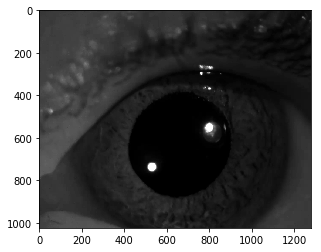

In [174]:

#testing on one image
test_frame = '20180921_JP_470_8/frame625.jpg'
img = get_image_mat(test_frame)
show_image(img)
print(img)
print(img.mean(axis=0).mean())


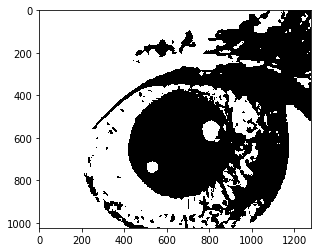

In [175]:
threshold = img.mean(axis=0).mean()*0.7
img = get_binary_image_mat(test_frame,threshold)
show_image(img)

In [177]:
test_estimate_center = np.array([600,800])
test_estimate_radius = 230

test_estimate_a = test_estimate_radius
test_estimate_b = test_estimate_radius

points = find_edge_points(test_estimate_center,test_estimate_radius,img)
a_points = np.array(points)
x = a_points[:, 0]
y = a_points[:, 1]
py.scatter(x,y, color="blue")



eye = fitEllipse(x,y)
center = ellipse_center(eye)

if isinstance(center[0], complex):
    center = test_estimate_center
    r = test_estimate_radius
    a = test_estimate_a
    b = test_estimate_b  
    
else:
    phi = ellipse_angle_of_rotation2(eye)
    axes = ellipse_axis_length(eye)
    a, b = axes
    area = np.pi*a*b
    r = np.sqrt(a*b)


print(center[0])
print ("center = ",  center)
print ("angle of rotation = ",  phi)
print ("axes = ", axes)
print ("area = ", area)
print ("radius = ", r)



R = np.arange(0,2*np.pi, 0.01)
xx = center[0] + a*np.cos(R)*np.cos(phi) - b*np.sin(R)*np.sin(phi)
yy = center[1] + a*np.cos(R)*np.sin(phi) + b*np.sin(R)*np.cos(phi)
py.plot(xx,yy, color = 'red')


IndexError: too many indices for array

In [ ]:
show_circle_img = get_image_mat(test_frame)
add_circle(show_circle_img,center,r,255)
#add_ellipse(show_circle_img,center,a,b,255)
show_image(show_circle_img)

In [ ]:
radius_data = []


estimate_center = np.array([600,800])


estimate_radius = 230

estimate_a = test_estimate_radius
estimate_b = test_estimate_radius


for i in range(1,n_frame+1):

    if i >2675:
        estimate_center = np.array([600,585])
    elif i > 2499:
        estimate_center = np.array([600,490])
    elif i > 1999:
        estimate_center = np.array([690,480])
    elif i > 1629:
        estimate_center = np.array([590,570])
    elif i > 1539:
        estimate_center = np.array([600,580])
    elif i > 1129:
        estimate_center = np.array([630,600])
    elif i > 859:
        estimate_center = np.array([630,630])
    elif i> 620:
        estimate_center = np.array([630,660])
    elif i > 549:
        estimate_center = np.array([650,710])    
    elif i > 434:
        estimate_center = np.array([620,710])
    
    elif i > 410:
        estimate_center = np.array([630,780])
        


    



    original_img = get_image_mat(input_frame.format(i))
    threshold = original_img.mean(axis=0).mean()
    
    print("FRAME", i)
    print("Prev thres:", threshold)


    
    if (0 <i<103) or (157 <i <434):
        if threshold < 50:
            threshold *= 0.3
            print("*0.3")
        else:
            threshold *= 0.4
            print("*0.4")
            
    elif (104 < i < 157):
        threshold *= 0.25
        print("*0.25")
        

    elif(434 < i < 467):
        threshold *= 0.67
        print("*0.67")
    elif (467<i<489):
        threshold *=0.58
        print("*0.58")
    elif (496<i<500):
        threshold *= 0.6
        print("*0.6")
    elif(499<i<583) or (332<i<903):
        threshold *= 0.52
        print("*0.52")
        
    else:
        if threshold < 50:
            threshold *= 0.64
            print("else *0.64")
        else:
            threshold *= 0.5
            print("*0.5")
            
    

            
    
    print("New thres:", threshold)
    
#    print(threshold)
    
    img = get_binary_image_mat(input_frame.format(i),threshold)
    
    points = find_edge_points(estimate_center,estimate_radius,img)

    if (len(points)>1):
        print(len(points))
        a_points = np.array(points)
        x = a_points[:, 0]
        y = a_points[:, 1]
        eye = fitEllipse(x,y)
        center = ellipse_center(eye)
        if isinstance(center[0], complex):
            center = estimate_center
            r = estimate_radius
            a = estimate_a
            b = estimate_b        
        else:
            phi = ellipse_angle_of_rotation2(eye)
            axes = ellipse_axis_length(eye)
            a, b = axes
            area = np.pi*a*b
            r = np.sqrt(a*b)
        

    #x-------------------------------------------------------------
    # In the case of blinking, bad detection, or complex
    # 451 - 464: Detection did not work with any threshold - returned an IndexError
    use_previous_frame = [103,104,157,220, 271,272,273,274,275,276,2772,78,279,280,281,282,283,284,285,286,287,288,289,
                          290,291,292,293,294,295,296,297,
                          288, 289, 290,291,292,293,294,295,432,433,434,450,453, 455,456,457,458,459,460,461,462,463,464, 467,
                          2724,2725,2726,2727,2728,2729,2730,2731,2756,2757,2758,2759,2760,2761,2761,2763,2764,2774,2775,2776,2777,
                          2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795, 2805,2806,2807,
                         2808,2809,2810,2811,2812,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837,
                         2838,2839,2840,2841,2842,2843,2844,2845,2846,2847,2848,2849,2850,2851,2852,2853,2854,2855]


    if (i in use_previous_frame) or (len(points)==0) or isNaN(r) or isNaN(center[0]):
        if i in use_previous_frame:
            print(i,"In use_previous_Frame")
        if len(points)==0:
            print(i,"Points empty")
        if isNaN(r):
            print(i,"isNaN(r) True")
        if isNaN(center[0]):
            print(i,"IsNaN(center[0]) True")
            

            
        r = prev_radius
        center = prev_center
        a = prev_a
        b = prev_b
        threshold = prev_threshold


    else:
        print(i, "Else statement")
        prev_radius = r
        prev_center = center
        prev_a = a
        prev_b = b
        prev_threshold = threshold
    

    radius_data.append(r)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        save_image(original_img,center,r,a,b,phi,output_frame.format(i)) 
        
export_to_csv(radius_data)

FRAME 1
Prev thres: 32.9470970154
*0.3
New thres: 9.88412910461


254
1 Else statement
FRAME 2
Prev thres: 32.9578025818
*0.3
New thres: 9.88734077454


252
2 Else statement
FRAME 3
Prev thres: 32.6999687195
*0.3
New thres: 9.80999061584


251
3 Else statement
FRAME 4
Prev thres: 32.271546936
*0.3
New thres: 9.68146408081


250
4 Else statement
FRAME 5
Prev thres: 32.2310440063
*0.3
New thres: 9.6693132019


256
5 Else statement
FRAME 6
Prev thres: 32.3359146118
*0.3
New thres: 9.70077438354


258
6 Else statement
FRAME 7
Prev thres: 32.1700561523
*0.3
New thres: 9.6510168457


251
7 Else statement
FRAME 8
Prev thres: 32.2866996765
*0.3
New thres: 9.68600990295


243
8 Else statement
FRAME 9
Prev thres: 32.3621955872
*0.3
New thres: 9.70865867615


245
9 Else statement
FRAME 10
Prev thres: 32.3947135925
*0.3
New thres: 9.71841407776


250
10 Else statement
FRAME 11
Prev thres: 32.5013244629
*0.3
New thres: 9.75039733887


245
11 Else statement
FRAME 12
Prev thres: 32.3887374878
*0.3
New thres: 9.71662124634


244
12 Else statement
FRAME 13
Prev thres: 32.3760726929
*0.3
New thres: 9.71282180786


243
13 Else statement
FRAME 14
Prev thres: 32.3557609558
*0.3
New thres: 9.70672828674


243
14 Else statement
FRAME 15
Prev thres: 32.3785400391
*0.3
New thres: 9.71356201172


259
15 Else statement
FRAME 16
Prev thres: 32.3703765869
*0.3
New thres: 9.71111297607


250
16 Else statement
FRAME 17
Prev thres: 32.3054763794
*0.3
New thres: 9.69164291382


248
17 Else statement
FRAME 18
Prev thres: 32.2461143494
*0.3
New thres: 9.67383430481


246
18 Else statement
FRAME 19
Prev thres: 32.2295974731
*0.3
New thres: 9.66887924194


248
19 Else statement
FRAME 20
Prev thres: 32.2229866028
*0.3
New thres: 9.66689598083


257
20 Else statement
FRAME 21
Prev thres: 32.2784004211
*0.3
New thres: 9.68352012634


251
21 Else statement
FRAME 22
Prev thres: 32.1391075134
*0.3
New thres: 9.64173225403


243
22 Else statement
FRAME 23
Prev thres: 32.0585388184
*0.3
New thres: 9.61756164551


245
23 Else statement
FRAME 24


Prev thres: 32.0620010376
*0.3
New thres: 9.61860031128
243
24 Else statement
FRAME 25
Prev thres: 32.2080032349
*0.3
New thres: 9.66240097046


255
25 Else statement
FRAME 26
Prev thres: 32.067779541
*0.3
New thres: 9.6203338623


248
26 Else statement
FRAME 27
Prev thres: 32.0581161499
*0.3
New thres: 9.61743484497


245
27 Else statement
FRAME 28
Prev thres: 32.0979621887
*0.3
New thres: 9.62938865662


251
28 Else statement
FRAME 29
Prev thres: 32.0438095093
*0.3
New thres: 9.61314285278


251
29 Else statement
FRAME 30
Prev thres: 32.1059234619
*0.3
New thres: 9.63177703857


256
30 Else statement
FRAME 31
Prev thres: 32.1765129089
*0.3
New thres: 9.65295387268


247
31 Else statement
FRAME 32
Prev thres: 31.9458679199
*0.3
New thres: 9.58376037598


243
32 Else statement
FRAME 33
Prev thres: 31.9464439392
*0.3
New thres: 9.58393318176


236
33 Else statement
FRAME 34
Prev thres: 31.8718185425
*0.3
New thres: 9.56154556274


235
34 Else statement
FRAME 35
Prev thres: 31.5578277588
*0.3
New thres: 9.46734832764


252
35 Else statement
FRAME 36
Prev thres: 31.9319641113
*0.3
New thres: 9.5795892334


238
36 Else statement
FRAME 37
Prev thres: 31.9150657654
*0.3
New thres: 9.57451972961


235
37 Else statement
FRAME 38
Prev thres: 31.7949615479
*0.3
New thres: 9.53848846436


238
38 Else statement
FRAME 39
Prev thres: 31.709463501
*0.3
New thres: 9.51283905029


242
39 Else statement
FRAME 40
Prev thres: 31.7927734375
*0.3
New thres: 9.53783203125


250
40 Else statement
FRAME 41
Prev thres: 31.8496986389
*0.3
New thres: 9.55490959167


246
41 Else statement
FRAME 42
Prev thres: 31.8791748047
*0.3
New thres: 9.56375244141


242
42 Else statement
FRAME 43
Prev thres: 32.0414978027
*0.3
New thres: 9.61244934082


244
43 Else statement
FRAME 44
Prev thres: 32.0532989502
*0.3
New thres: 9.61598968506


247
44 Else statement
FRAME 45
Prev thres: 32.4547698975
*0.3
New thres: 9.73643096924


260
45 Else statement
FRAME 46
Prev thres: 32.5009803772
*0.3
New thres: 9.75029411316


248
46 Else statement
FRAME 47
Prev thres: 32.2243110657
*0.3
New thres: 9.6672933197


245
47 Else statement
FRAME 48
Prev thres: 32.1874519348
*0.3
New thres: 9.65623558044


240
48 Else statement
FRAME 49
Prev thres: 32.0941589355
*0.3
New thres: 9.62824768066


240
49 Else statement
FRAME 50
Prev thres: 31.8618804932
*0.3
New thres: 9.55856414795


258
50 Else statement
FRAME 51
Prev thres: 33.0079147339
*0.3
New thres: 9.90237442017


217
51 Else statement
FRAME 52
Prev thres: 32.6534408569
*0.3
New thres: 9.79603225708
